# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [7]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


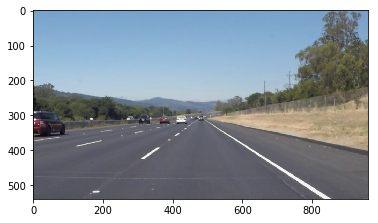

In [8]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [30]:
import math
import collections

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    global buffered_frames
    buffered_frames = collections.deque([], 5)
    leftLaneLine_Points  = [];
    leftLaneSlopes       = [];
    rightLaneLine_Points = [];
    rightLaneSlopes      = [];
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1);
            # Eliminate pathological cases and anyline slope below 0.5
            if np.absolute(slope) == np.inf or np.absolute(slope) < 0.5:
                continue
            # Group lines into left laneline or roght laneline
            # based on slope being +ve for left laneline and -Ve for right laneline
            if slope < 0:
                #rightLaneSlopes.append(slope);
                #if np.absolute(np.average(rightLaneSlopes)-slope) < 0.1:                    
                    rightLaneLine_Points.append((x1,y1));
                    rightLaneLine_Points.append((x2,y2));                
            else:
                #leftLaneSlopes.append(slope);
                #if np.absolute(np.average(leftLaneSlopes)-slope) < 0.1:                
                    leftLaneLine_Points.append((x1,y1));
                    leftLaneLine_Points.append((x2,y2));
                
    # Get (m,b) paramteres of the line that fits all points in each group
    if len(rightLaneLine_Points) > 0 and len(leftLaneLine_Points) > 0:
        # right lane
        [vx, vy, x, y] = cv2.fitLine(np.array(rightLaneLine_Points, dtype=np.int32), cv2.DIST_L2, 0, 0.01, 0.01);
        rightLaneSlope = vy / vx;
        rightLaneIntercept = y - (rightLaneSlope * x);            
        # left lane
        [vx, vy, x, y] = cv2.fitLine(np.array(leftLaneLine_Points, dtype=np.int32), cv2.DIST_L2, 0, 0.01, 0.01);
        leftLaneSlope = vy / vx;
        leftLaneIntercept = y - (leftLaneSlope * x); 
        buffered_frames.append((rightLaneSlope,rightLaneIntercept, leftLaneSlope, leftLaneIntercept))
            
    if len(buffered_frames) > 0:
        # Use average of lane parameters from previous 3 frames
        avg = np.sum(buffered_frames, -3) / len(buffered_frames)
        rightLaneSlope = avg[0]
        rightLaneIntercept = avg[1]
        leftLaneSlope = avg[2]
        leftLaneIntercept = avg[3]    
        
        # chose the start and end Y values    
        startY = img.shape[0];
        endY   = int(startY / 1.6);

        # calculate start and end X values for both sides
        rightLaneStartX = int((startY - rightLaneIntercept) / rightLaneSlope);
        rightLaneEndX = int((endY - rightLaneIntercept) / rightLaneSlope);

        leftLaneStartX = int((startY - leftLaneIntercept) / leftLaneSlope);
        leftLaneEndX = int((endY - leftLaneIntercept) / leftLaneSlope);
        print(rightLaneStartX, rightLaneEndX, leftLaneStartX, leftLaneEndX);
        """
        Draw left and right lane lines according to their new x1 and x2 start and end points
        """
        cv2.line(img, (rightLaneStartX, startY), (rightLaneEndX, endY), color, thickness);
        cv2.line(img, (leftLaneStartX, startY), (leftLaneEndX, endY), color, thickness);   

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines,color=[0, 255, 0], thickness=8)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [10]:
import os
os.listdir("test_images/")

['detected',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

In [11]:
image = mpimg.imread("test_images/solidWhiteCurve.jpg")
print(image.shape)

(540, 960, 3)


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [27]:
# TODO: Build your pipeline that will draw lane lines on the test_images
def detect_lanes(image):
    
    imshape = image.shape
    ysize = imshape[0]
    xsize = imshape[1]
    
    #1. Convert to Gray Scale
    gray = grayscale(image);
    
    #2. Do Gaussian Blurring
    kernel_size = 7;
    gray_blur = gaussian_blur(gray, kernel_size);
    
    #3. Perform Canny Edge Detection
    low_threshold = 10
    high_threshold = 160
    edges = canny(gray_blur, low_threshold, high_threshold);
    
    #4. Get Masked edges using Region of interest

    vertices = np.array([[(40,ysize),(xsize/2, ysize/2+40), (xsize/2, ysize/2+40),(xsize - 40,ysize)]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices);
    
    #5. Detect lines in masked image using Hough transform
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 30    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 30 #minimum number of pixels making up a line
    max_line_gap = 10    # maximum gap in pixels between connectable line segments    
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap);
    
    #6. Get final_image with detected lanes overlayed on the original image
    final_img = weighted_img(line_image, image, α=0.6, β=1, λ=0)
    
    return edges, masked_edges, final_img


test_images\solidWhiteCurve.jpg
181 447 889 531
test_images\solidWhiteRight.jpg
141 440 842 526
test_images\solidYellowCurve.jpg
164 441 855 516
test_images\solidYellowCurve2.jpg
169 442 870 517
test_images\solidYellowLeft.jpg
147 433 850 528
test_images\whiteCarLaneSwitch.jpg
184 449 875 527


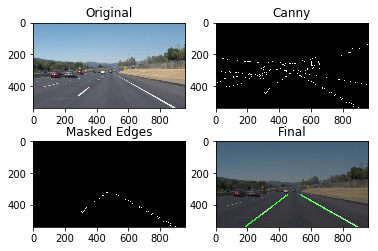

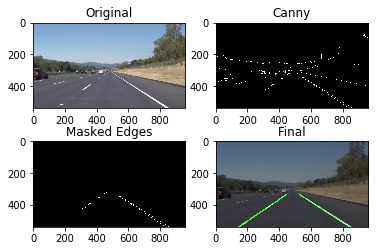

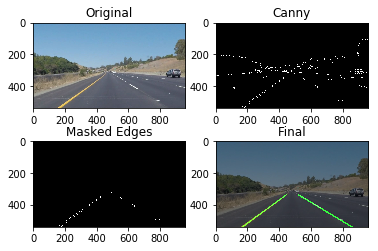

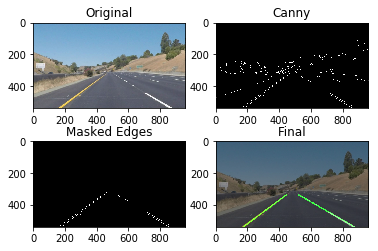

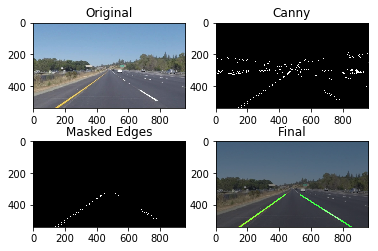

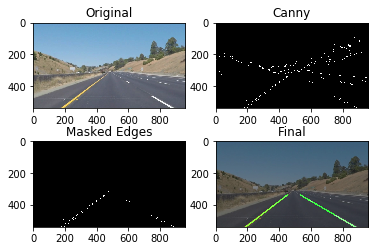

In [28]:
# then save them to the test_images directory.
import glob
paths = glob.glob('test_images/*.jpg')

for i,img_file in enumerate(paths):
    print(img_file)
    image = mpimg.imread(img_file)
    edges, masked_edges, final_img = detect_lanes(image)
    outfile = 'test_images/detected/'+ os.path.basename(img_file) + "_final.jpg"
    mpimg.imsave(outfile, final_img)    
    # plot the images at different stages of pipeline
    plt.figure(figsize=(160,160))
    fig = plt.figure()
    a=fig.add_subplot(2,2,1)
    plt.imshow(image)
    a.set_title('Original')

    a=fig.add_subplot(2,2,2)
    plt.imshow(edges, cmap='Greys_r')
    a.set_title('Canny')

    a=fig.add_subplot(2,2,3)
    plt.imshow(masked_edges, cmap='Greys_r')
    a.set_title('Masked Edges')

    a=fig.add_subplot(2,2,4)
    plt.imshow(final_img)
    a.set_title('Final')

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [23]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [24]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    edges, masked_edges, final_img = detect_lanes(image)
    return final_img

Let's try the one with the solid white lane on the right first ...

In [31]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

157 436 860 531
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



  0%|                                                                                          | 0/222 [00:00<?, ?it/s]

157 436 860 531



  0%|▎                                                                                 | 1/222 [00:00<00:23,  9.61it/s]

157 437 862 529
157 438 861 528



  1%|█                                                                                 | 3/222 [00:00<00:20, 10.65it/s]

156 436 858 529



  2%|█▊                                                                                | 5/222 [00:00<00:17, 12.36it/s]

142 436 857 531



  3%|██▌                                                                               | 7/222 [00:00<00:15, 13.87it/s]

144 438 867 533
149 437 865 529



  4%|███▎                                                                              | 9/222 [00:00<00:14, 14.48it/s]

149 439 855 527
159 437 854 523



  5%|████                                                                             | 11/222 [00:00<00:14, 14.14it/s]

155 441 847 524
155 440 849 526



  6%|████▋                                                                            | 13/222 [00:00<00:15, 13.91it/s]

153 435 851 526
146 440 852 527



  7%|█████▍                                                                           | 15/222 [00:01<00:14, 14.08it/s]

142 449 849 534



  8%|██████▏                                                                          | 17/222 [00:01<00:13, 14.76it/s]

129 433 845 529
137 439 845 526



  9%|███████▎                                                                         | 20/222 [00:01<00:12, 15.84it/s]

132 444 844 526
140 441 845 526



 10%|████████                                                                         | 22/222 [00:01<00:12, 15.77it/s]

146 442 843 527
144 441 845 528



 11%|████████▊                                                                        | 24/222 [00:01<00:12, 16.03it/s]

147 441 841 526
149 439 841 527



 12%|█████████▍                                                                       | 26/222 [00:01<00:12, 15.56it/s]

153 430 840 527
150 448 844 526



 13%|██████████▏                                                                      | 28/222 [00:01<00:13, 14.49it/s]

131 435 848 530



 14%|███████████▎                                                                     | 31/222 [00:01<00:11, 16.18it/s]

151 436 848 531
144 438 852 531



 15%|████████████                                                                     | 33/222 [00:02<00:11, 15.93it/s]

147 436 846 529
152 436 849 528



 16%|████████████▊                                                                    | 35/222 [00:02<00:12, 15.46it/s]

150 442 851 526
152 440 850 526



 17%|█████████████▌                                                                   | 37/222 [00:02<00:11, 15.62it/s]

151 437 846 527
153 436 845 527



 18%|██████████████▏                                                                  | 39/222 [00:02<00:11, 16.14it/s]

149 453 849 527



 19%|███████████████▎                                                                 | 42/222 [00:02<00:10, 17.90it/s]

143 435 846 532
151 431 845 532



 20%|████████████████                                                                 | 44/222 [00:02<00:10, 17.01it/s]

147 433 841 535
149 433 839 533



 21%|████████████████▊                                                                | 46/222 [00:02<00:10, 16.82it/s]

154 431 840 532
149 430 846 534



 22%|█████████████████▌                                                               | 48/222 [00:03<00:14, 12.42it/s]

147 429 845 532
150 434 843 533



 23%|██████████████████▏                                                              | 50/222 [00:03<00:13, 13.00it/s]

148 434 849 530
142 442 844 533



 23%|██████████████████▉                                                              | 52/222 [00:03<00:13, 13.02it/s]

131 434 846 533
97 436 845 532



 24%|███████████████████▋                                                             | 54/222 [00:03<00:14, 11.81it/s]

124 434 846 528
134 433 843 528



 25%|████████████████████▍                                                            | 56/222 [00:03<00:17,  9.56it/s]

139 436 840 526
137 432 841 526



 26%|█████████████████████▏                                                           | 58/222 [00:04<00:15, 10.27it/s]

131 437 837 526
135 436 842 526



 27%|█████████████████████▉                                                           | 60/222 [00:04<00:16,  9.86it/s]

137 436 838 525
141 436 831 526



 28%|██████████████████████▌                                                          | 62/222 [00:04<00:15, 10.27it/s]

137 441 841 525
134 444 839 524



 29%|███████████████████████▎                                                         | 64/222 [00:04<00:14, 11.17it/s]

137 437 837 525



 30%|████████████████████████                                                         | 66/222 [00:04<00:14, 10.77it/s]

104 432 838 526
129 434 841 527



 31%|████████████████████████▊                                                        | 68/222 [00:05<00:14, 10.73it/s]

129 432 833 529
125 434 840 526



 32%|█████████████████████████▌                                                       | 70/222 [00:05<00:13, 11.34it/s]

126 434 831 528
131 429 836 528



 32%|██████████████████████████▎                                                      | 72/222 [00:05<00:16,  9.15it/s]

128 433 834 527
129 431 832 526



 33%|███████████████████████████                                                      | 74/222 [00:05<00:15,  9.77it/s]

124 443 834 525
125 443 835 525



 34%|███████████████████████████▋                                                     | 76/222 [00:05<00:15,  9.20it/s]

119 479 832 525



 35%|████████████████████████████▍                                                    | 78/222 [00:06<00:23,  6.04it/s]

116 433 827 525



 36%|████████████████████████████▊                                                    | 79/222 [00:06<00:22,  6.22it/s]

118 433 828 525



 36%|█████████████████████████████▏                                                   | 80/222 [00:06<00:23,  5.95it/s]

113 434 822 527



 36%|█████████████████████████████▌                                                   | 81/222 [00:06<00:29,  4.77it/s]

109 434 827 527



 37%|█████████████████████████████▉                                                   | 82/222 [00:07<00:31,  4.45it/s]

117 430 826 524



 37%|██████████████████████████████▎                                                  | 83/222 [00:07<00:30,  4.62it/s]

121 434 826 527



 38%|██████████████████████████████▋                                                  | 84/222 [00:07<00:28,  4.92it/s]

117 435 829 525



 38%|███████████████████████████████                                                  | 85/222 [00:07<00:26,  5.17it/s]

120 433 826 527



 39%|███████████████████████████████▍                                                 | 86/222 [00:08<00:29,  4.54it/s]

120 432 825 527



 39%|███████████████████████████████▋                                                 | 87/222 [00:08<00:25,  5.28it/s]

123 442 827 525



 40%|████████████████████████████████                                                 | 88/222 [00:08<00:23,  5.82it/s]

122 433 826 525



 41%|████████████████████████████████▊                                                | 90/222 [00:08<00:22,  5.75it/s]

117 434 822 523



 41%|█████████████████████████████████▏                                               | 91/222 [00:08<00:20,  6.51it/s]

117 438 818 526
115 439 815 525



 42%|█████████████████████████████████▉                                               | 93/222 [00:08<00:17,  7.43it/s]

120 438 818 527



 42%|██████████████████████████████████▎                                              | 94/222 [00:09<00:23,  5.49it/s]

124 435 820 530



 43%|██████████████████████████████████▋                                              | 95/222 [00:09<00:26,  4.71it/s]

125 436 825 528



 43%|███████████████████████████████████                                              | 96/222 [00:09<00:24,  5.21it/s]

128 435 817 534
125 433 822 534



 44%|███████████████████████████████████▊                                             | 98/222 [00:10<00:23,  5.30it/s]

123 434 822 534



 45%|████████████████████████████████████                                             | 99/222 [00:10<00:21,  5.75it/s]

123 434 823 534



 45%|████████████████████████████████████                                            | 100/222 [00:10<00:18,  6.44it/s]

118 480 822 533



 46%|████████████████████████████████████▊                                           | 102/222 [00:10<00:15,  7.71it/s]

132 436 826 530



 46%|█████████████████████████████████████                                           | 103/222 [00:10<00:15,  7.58it/s]

126 441 825 529
135 439 827 530



 47%|█████████████████████████████████████▊                                          | 105/222 [00:10<00:13,  8.51it/s]

131 438 825 532



 48%|██████████████████████████████████████▏                                         | 106/222 [00:10<00:13,  8.30it/s]

130 440 828 535



 48%|██████████████████████████████████████▌                                         | 107/222 [00:10<00:13,  8.39it/s]

134 437 833 533



 49%|██████████████████████████████████████▉                                         | 108/222 [00:11<00:12,  8.79it/s]

133 438 831 533



 49%|███████████████████████████████████████▎                                        | 109/222 [00:11<00:13,  8.63it/s]

133 437 830 533
139 437 830 532



 50%|████████████████████████████████████████                                        | 111/222 [00:11<00:12,  9.24it/s]

140 436 830 533
136 440 832 535



 51%|████████████████████████████████████████▋                                       | 113/222 [00:11<00:11,  9.55it/s]

101 439 835 534
126 436 837 536



 52%|█████████████████████████████████████████▍                                      | 115/222 [00:11<00:10,  9.84it/s]

132 435 838 535
125 437 840 533



 53%|██████████████████████████████████████████▏                                     | 117/222 [00:11<00:11,  9.54it/s]

125 438 838 534



 53%|██████████████████████████████████████████▌                                     | 118/222 [00:12<00:11,  9.27it/s]

126 438 838 529
130 440 839 532



 54%|███████████████████████████████████████████▏                                    | 120/222 [00:12<00:10,  9.45it/s]

138 436 849 530
140 439 840 529



 55%|███████████████████████████████████████████▉                                    | 122/222 [00:12<00:10,  9.39it/s]

137 439 847 530
134 440 848 530



 56%|████████████████████████████████████████████▋                                   | 124/222 [00:12<00:09,  9.83it/s]

139 442 848 532



 57%|█████████████████████████████████████████████▍                                  | 126/222 [00:12<00:09, 10.07it/s]

132 441 849 530
136 443 846 531



 58%|██████████████████████████████████████████████▏                                 | 128/222 [00:13<00:08, 10.47it/s]

144 441 850 532
143 443 852 530



 59%|██████████████████████████████████████████████▊                                 | 130/222 [00:13<00:08, 10.57it/s]

148 444 851 530
152 445 853 530



 59%|███████████████████████████████████████████████▌                                | 132/222 [00:13<00:10,  8.97it/s]

153 441 852 530
151 437 852 531



 60%|████████████████████████████████████████████████▎                               | 134/222 [00:13<00:09,  9.69it/s]

149 439 851 533
147 445 855 535



 61%|█████████████████████████████████████████████████                               | 136/222 [00:13<00:08,  9.66it/s]

142 455 859 536



 62%|█████████████████████████████████████████████████▋                              | 138/222 [00:14<00:08, 10.35it/s]

144 434 860 535
146 440 855 532



 63%|██████████████████████████████████████████████████▍                             | 140/222 [00:14<00:08, 10.07it/s]

144 442 852 531
155 441 852 530



 64%|███████████████████████████████████████████████████▏                            | 142/222 [00:14<00:08,  9.47it/s]

158 441 847 530



 64%|███████████████████████████████████████████████████▌                            | 143/222 [00:14<00:09,  8.76it/s]

158 439 846 530
157 446 852 531



 65%|████████████████████████████████████████████████████▎                           | 145/222 [00:14<00:08,  9.50it/s]

157 440 855 533
158 437 855 536



 66%|████████████████████████████████████████████████████▉                           | 147/222 [00:14<00:07, 10.20it/s]

158 437 857 535
156 454 858 538



 67%|█████████████████████████████████████████████████████▋                          | 149/222 [00:15<00:07,  9.91it/s]

167 443 863 538



 68%|██████████████████████████████████████████████████████▍                         | 151/222 [00:15<00:07, 10.09it/s]

152 443 859 537
159 444 860 537



 69%|███████████████████████████████████████████████████████▏                        | 153/222 [00:15<00:06, 10.24it/s]

155 443 863 538
157 443 861 539



 70%|███████████████████████████████████████████████████████▊                        | 155/222 [00:15<00:07,  9.38it/s]

161 441 864 539
162 437 864 538



 71%|████████████████████████████████████████████████████████▌                       | 157/222 [00:15<00:06, 10.28it/s]

162 439 868 536
167 441 868 538



 72%|█████████████████████████████████████████████████████████▎                      | 159/222 [00:16<00:05, 10.59it/s]

163 447 874 536
166 445 876 537



 73%|██████████████████████████████████████████████████████████                      | 161/222 [00:16<00:06,  9.72it/s]

156 443 878 538



 73%|██████████████████████████████████████████████████████████▋                     | 163/222 [00:16<00:05, 11.15it/s]

162 442 881 534
166 447 878 532



 74%|███████████████████████████████████████████████████████████▍                    | 165/222 [00:16<00:05, 11.04it/s]

172 448 881 533
176 447 875 532



 75%|████████████████████████████████████████████████████████████▏                   | 167/222 [00:16<00:04, 11.06it/s]

174 448 876 531
179 445 875 531



 76%|████████████████████████████████████████████████████████████▉                   | 169/222 [00:17<00:05, 10.50it/s]

177 444 876 531
181 443 874 531



 77%|█████████████████████████████████████████████████████████████▌                  | 171/222 [00:17<00:04, 10.70it/s]

182 443 877 531
179 469 878 532



 79%|███████████████████████████████████████████████████████████████                 | 175/222 [00:17<00:04, 11.51it/s]

171 444 879 531
175 446 881 530



 80%|███████████████████████████████████████████████████████████████▊                | 177/222 [00:17<00:03, 11.79it/s]

183 445 879 531
181 445 875 532



 81%|████████████████████████████████████████████████████████████████▌               | 179/222 [00:18<00:04, 10.40it/s]

186 442 881 534
183 445 881 534



 82%|█████████████████████████████████████████████████████████████████▏              | 181/222 [00:18<00:04,  9.34it/s]

193 445 883 535



 82%|█████████████████████████████████████████████████████████████████▌              | 182/222 [00:18<00:04,  9.42it/s]

187 443 883 535
188 442 882 536



 83%|██████████████████████████████████████████████████████████████████▎             | 184/222 [00:18<00:03,  9.84it/s]

187 441 874 538



 84%|███████████████████████████████████████████████████████████████████             | 186/222 [00:18<00:03,  9.20it/s]

159 442 874 539
175 437 881 537



 85%|███████████████████████████████████████████████████████████████████▋            | 188/222 [00:18<00:03, 10.09it/s]

177 439 890 540
172 437 897 546



 86%|████████████████████████████████████████████████████████████████████▍           | 190/222 [00:19<00:03, 10.49it/s]

175 437 897 536
180 442 894 536



 86%|█████████████████████████████████████████████████████████████████████▏          | 192/222 [00:19<00:03,  9.95it/s]

186 446 890 533
184 444 886 531



 87%|█████████████████████████████████████████████████████████████████████▉          | 194/222 [00:19<00:02, 10.53it/s]

188 447 881 532
184 444 876 532



 88%|██████████████████████████████████████████████████████████████████████▋         | 196/222 [00:19<00:02, 11.01it/s]

183 464 884 531



 89%|███████████████████████████████████████████████████████████████████████▎        | 198/222 [00:19<00:02, 10.43it/s]

172 439 884 532
167 443 884 533



 90%|████████████████████████████████████████████████████████████████████████        | 200/222 [00:20<00:02, 10.25it/s]

183 444 886 533
177 444 889 534



 91%|████████████████████████████████████████████████████████████████████████▊       | 202/222 [00:20<00:01, 10.52it/s]

178 442 891 534
178 443 888 535



 92%|█████████████████████████████████████████████████████████████████████████▌      | 204/222 [00:20<00:01, 10.41it/s]

180 445 893 536
185 440 897 534



 93%|██████████████████████████████████████████████████████████████████████████▏     | 206/222 [00:20<00:01,  9.75it/s]

180 443 893 536
183 455 890 537



 94%|██████████████████████████████████████████████████████████████████████████▉     | 208/222 [00:20<00:01, 10.54it/s]

183 460 898 536



 95%|███████████████████████████████████████████████████████████████████████████▋    | 210/222 [00:21<00:01, 11.02it/s]

181 441 896 532



 96%|████████████████████████████████████████████████████████████████████████████▊   | 213/222 [00:21<00:00, 12.34it/s]

186 443 894 528
176 445 892 532



 97%|█████████████████████████████████████████████████████████████████████████████▍  | 215/222 [00:21<00:00, 11.18it/s]

181 445 890 530
180 446 888 530



 98%|██████████████████████████████████████████████████████████████████████████████▏ | 217/222 [00:21<00:00, 11.50it/s]

182 439 890 530
185 443 890 531



 99%|██████████████████████████████████████████████████████████████████████████████▉ | 219/222 [00:21<00:00, 10.86it/s]

187 445 890 530
183 461 889 530



100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:22<00:00,  9.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 23.7 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [34]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

113 439 834 526
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



  0%|                                                                                          | 0/682 [00:00<?, ?it/s]

113 439 834 526



  0%|                                                                                  | 1/682 [00:00<01:25,  7.93it/s]

112 440 833 522
113 440 836 531



  0%|▎                                                                                 | 3/682 [00:00<01:12,  9.34it/s]

116 440 833 516
122 443 837 490



  1%|▌                                                                                 | 5/682 [00:00<01:05, 10.28it/s]

132 442 853 527



  1%|▊                                                                                 | 7/682 [00:00<00:56, 11.97it/s]

129 441 844 529
126 442 852 530



  1%|█                                                                                 | 9/682 [00:00<00:53, 12.62it/s]

129 440 847 532
131 441 852 530



  2%|█▎                                                                               | 11/682 [00:00<00:50, 13.26it/s]

130 438 853 530
133 442 851 535



  2%|█▌                                                                               | 13/682 [00:00<00:48, 13.89it/s]

133 441 852 522
139 441 848 530



  2%|█▊                                                                               | 15/682 [00:01<00:47, 14.06it/s]

142 440 853 529
141 440 851 516



  2%|██                                                                               | 17/682 [00:01<00:44, 15.08it/s]

144 439 876 531
145 437 869 528



  3%|██▍                                                                              | 20/682 [00:01<00:40, 16.17it/s]

140 437 861 530
142 435 865 531



  3%|██▌                                                                              | 22/682 [00:01<00:40, 16.31it/s]

138 437 858 534
137 435 858 534



  4%|██▊                                                                              | 24/682 [00:01<00:40, 16.18it/s]

138 437 856 533
140 442 858 534



  4%|███                                                                              | 26/682 [00:01<00:40, 16.16it/s]

147 439 862 529
152 436 862 533



  4%|███▎                                                                             | 28/682 [00:01<00:41, 15.69it/s]

147 437 865 526
149 436 870 490



  4%|███▌                                                                             | 30/682 [00:01<00:40, 16.00it/s]

151 435 880 531
150 435 870 538



  5%|███▊                                                                             | 32/682 [00:02<00:41, 15.55it/s]

149 434 889 534
152 433 884 532



  5%|████                                                                             | 34/682 [00:02<00:40, 16.17it/s]

156 433 881 533
154 434 880 532



  5%|████▎                                                                            | 36/682 [00:02<00:38, 16.68it/s]

156 431 878 537
152 432 876 537



  6%|████▌                                                                            | 38/682 [00:02<00:39, 16.31it/s]

152 430 881 537
151 430 879 534



  6%|████▊                                                                            | 40/682 [00:02<00:39, 16.41it/s]

149 429 879 530
154 430 876 521
157 428 890 532



  6%|█████                                                                            | 43/682 [00:02<00:37, 17.25it/s]

151 430 874 532
155 430 863 539



  7%|█████▎                                                                           | 45/682 [00:02<00:38, 16.47it/s]

153 430 882 532
153 430 880 531



  7%|█████▌                                                                           | 47/682 [00:03<00:46, 13.79it/s]

147 430 870 533
152 429 875 533



  7%|█████▊                                                                           | 49/682 [00:03<00:44, 14.26it/s]

152 427 870 535
150 428 866 533



  7%|██████                                                                           | 51/682 [00:03<00:44, 14.26it/s]

147 427 871 535
154 429 871 524



  8%|██████▎                                                                          | 53/682 [00:03<00:53, 11.81it/s]

149 429 870 524
153 430 873 484



  8%|██████▌                                                                          | 55/682 [00:03<01:04,  9.67it/s]

152 428 878 530
151 429 878 528



  8%|██████▊                                                                          | 57/682 [00:04<01:01, 10.11it/s]

152 432 872 528
150 430 865 530



  9%|███████                                                                          | 59/682 [00:04<01:05,  9.55it/s]

152 432 871 525
151 433 872 527



  9%|███████▏                                                                         | 61/682 [00:04<01:09,  9.00it/s]

140 429 865 524
146 429 864 528



  9%|███████▍                                                                         | 63/682 [00:04<01:02,  9.91it/s]

145 428 864 533
142 429 865 527



 10%|███████▋                                                                         | 65/682 [00:04<00:57, 10.68it/s]

141 429 865 513
143 431 860 513



 10%|███████▉                                                                         | 67/682 [00:05<01:03,  9.63it/s]

145 433 817 544



 10%|████████▏                                                                        | 69/682 [00:05<00:54, 11.19it/s]

140 432 843 532
143 433 836 536



 10%|████████▍                                                                        | 71/682 [00:05<00:50, 11.99it/s]

149 433 843 531
146 434 859 526



 11%|████████▋                                                                        | 73/682 [00:05<00:58, 10.49it/s]

149 434 859 523
147 433 858 524



 11%|████████▉                                                                        | 75/682 [00:05<00:53, 11.26it/s]

148 434 856 526
147 433 856 519



 11%|█████████▏                                                                       | 77/682 [00:05<00:54, 11.14it/s]

146 434 849 526
145 432 850 516



 12%|█████████▍                                                                       | 79/682 [00:06<00:57, 10.48it/s]

145 431 850 507
144 434 869 529



 12%|█████████▌                                                                       | 81/682 [00:06<00:54, 11.08it/s]

142 430 856 528
143 430 852 526



 12%|█████████▊                                                                       | 83/682 [00:06<00:55, 10.75it/s]

143 429 854 527
145 431 848 529



 12%|██████████                                                                       | 85/682 [00:06<00:54, 10.98it/s]

143 432 852 527
140 433 851 528



 13%|██████████▎                                                                      | 87/682 [00:06<00:51, 11.47it/s]

134 433 853 525
138 431 855 522



 13%|██████████▌                                                                      | 89/682 [00:07<00:56, 10.56it/s]

139 434 845 529
136 434 842 528



 13%|██████████▊                                                                      | 91/682 [00:07<00:56, 10.45it/s]

137 435 851 504
139 437 854 454



 14%|███████████                                                                      | 93/682 [00:07<00:52, 11.12it/s]

143 438 848 525



 14%|███████████▎                                                                     | 95/682 [00:07<00:51, 11.40it/s]

148 440 845 523
147 440 851 520



 14%|███████████▌                                                                     | 97/682 [00:07<00:50, 11.62it/s]

145 438 843 525
142 438 852 522



 15%|███████████▊                                                                     | 99/682 [00:07<00:54, 10.62it/s]

145 439 850 524
144 439 843 523



 15%|███████████▊                                                                    | 101/682 [00:08<00:53, 10.92it/s]

145 437 850 525
139 438 842 526



 15%|████████████                                                                    | 103/682 [00:08<00:54, 10.61it/s]

141 436 845 526
136 435 846 529



 15%|████████████▎                                                                   | 105/682 [00:08<00:55, 10.48it/s]

137 435 850 475



 16%|████████████▌                                                                   | 107/682 [00:08<00:50, 11.33it/s]

138 436 861 524
139 436 847 525



 16%|████████████▊                                                                   | 109/682 [00:08<00:53, 10.77it/s]

139 438 845 524
141 438 849 522



 16%|█████████████                                                                   | 111/682 [00:08<00:50, 11.23it/s]

145 437 853 520
142 439 851 526



 17%|█████████████▎                                                                  | 113/682 [00:09<00:55, 10.17it/s]

146 437 855 518
144 438 848 532



 17%|█████████████▍                                                                  | 115/682 [00:09<00:52, 10.75it/s]

146 439 851 528
138 437 851 523



 17%|█████████████▋                                                                  | 117/682 [00:09<00:47, 11.80it/s]

144 437 849 527
146 439 864 503



 17%|█████████████▉                                                                  | 119/682 [00:09<01:05,  8.56it/s]

152 438 855 527
148 436 855 526



 18%|██████████████▏                                                                 | 121/682 [00:10<00:59,  9.45it/s]

146 438 856 525
149 438 852 529



 18%|██████████████▍                                                                 | 123/682 [00:10<00:53, 10.39it/s]

145 438 844 527
148 438 849 528



 18%|██████████████▋                                                                 | 125/682 [00:10<00:52, 10.61it/s]

147 438 852 520
146 437 850 528



 19%|██████████████▉                                                                 | 127/682 [00:10<00:55,  9.96it/s]

150 440 848 529
151 441 849 524



 19%|███████████████▏                                                                | 129/682 [00:10<00:54, 10.22it/s]

152 439 854 527
146 439 848 527



 19%|███████████████▎                                                                | 131/682 [00:10<00:52, 10.47it/s]

151 439 876 528
149 439 859 527



 20%|███████████████▌                                                                | 133/682 [00:11<00:53, 10.18it/s]

153 439 855 526
151 439 849 525



 20%|███████████████▊                                                                | 135/682 [00:11<00:50, 10.74it/s]

151 439 850 524
148 440 856 525



 20%|████████████████                                                                | 137/682 [00:11<00:52, 10.41it/s]

150 440 852 525
152 439 853 526



 20%|████████████████▎                                                               | 139/682 [00:11<00:57,  9.38it/s]

151 440 854 524
151 439 850 524



 21%|████████████████▌                                                               | 141/682 [00:11<00:53, 10.06it/s]

146 439 852 521
153 440 855 505



 21%|████████████████▊                                                               | 143/682 [00:12<00:57,  9.43it/s]

151 440 858 524



 21%|█████████████████                                                               | 145/682 [00:12<00:54,  9.93it/s]

147 438 856 522
147 438 854 523



 22%|█████████████████▏                                                              | 147/682 [00:12<00:50, 10.65it/s]

148 439 868 520
144 441 861 523



 22%|█████████████████▍                                                              | 149/682 [00:12<00:55,  9.67it/s]

147 441 859 523
150 441 859 524



 22%|█████████████████▋                                                              | 151/682 [00:13<00:55,  9.51it/s]

153 440 852 528
146 441 855 524



 22%|█████████████████▉                                                              | 153/682 [00:13<00:51, 10.29it/s]

152 445 860 523
150 444 858 515



 23%|██████████████████▏                                                             | 155/682 [00:13<00:50, 10.52it/s]

151 448 860 469
152 447 864 526



 23%|██████████████████▍                                                             | 157/682 [00:13<00:53,  9.87it/s]

156 447 865 522
157 450 862 521



 23%|██████████████████▋                                                             | 159/682 [00:13<00:53,  9.82it/s]

157 448 868 517
159 450 869 518



 24%|██████████████████▉                                                             | 161/682 [00:13<00:49, 10.44it/s]

158 447 864 523
162 449 867 525



 24%|███████████████████                                                             | 163/682 [00:14<00:55,  9.41it/s]

158 449 866 524
157 447 866 523



 24%|███████████████████▎                                                            | 165/682 [00:14<00:51, 10.10it/s]

158 446 871 524
162 446 869 527



 24%|███████████████████▌                                                            | 167/682 [00:14<00:47, 10.84it/s]

160 448 872 509



 25%|███████████████████▊                                                            | 169/682 [00:14<00:49, 10.26it/s]

169 449 880 524
167 448 882 524



 25%|████████████████████                                                            | 171/682 [00:14<00:48, 10.55it/s]

168 447 888 525
171 448 872 529



 25%|████████████████████▎                                                           | 173/682 [00:15<00:46, 11.06it/s]

173 445 885 526
170 446 884 527



 26%|████████████████████▌                                                           | 175/682 [00:15<00:48, 10.50it/s]

172 446 886 527
178 445 887 522



 26%|████████████████████▊                                                           | 177/682 [00:15<00:48, 10.37it/s]

178 448 880 534
180 446 882 532



 26%|████████████████████▉                                                           | 179/682 [00:15<00:46, 10.80it/s]

177 445 886 515
180 445 883 534



 27%|█████████████████████▏                                                          | 181/682 [00:15<00:46, 10.67it/s]

175 444 910 522
177 445 903 524



 27%|█████████████████████▍                                                          | 183/682 [00:16<00:47, 10.55it/s]

177 445 890 524
178 447 892 524



 27%|█████████████████████▋                                                          | 185/682 [00:16<00:46, 10.59it/s]

178 446 885 525
178 447 887 525



 27%|█████████████████████▉                                                          | 187/682 [00:16<00:45, 10.92it/s]

182 446 886 526
181 446 888 523



 28%|██████████████████████▏                                                         | 189/682 [00:16<00:48, 10.21it/s]

180 444 887 525
182 446 889 517



 28%|██████████████████████▍                                                         | 191/682 [00:16<00:46, 10.63it/s]

185 444 890 520
184 444 889 501



 28%|██████████████████████▋                                                         | 193/682 [00:16<00:44, 11.09it/s]

181 442 897 522



 29%|██████████████████████▊                                                         | 195/682 [00:17<00:43, 11.09it/s]

180 443 893 520
179 443 895 522



 29%|███████████████████████                                                         | 197/682 [00:17<00:44, 10.99it/s]

174 443 889 519
178 441 881 522



 29%|███████████████████████▎                                                        | 199/682 [00:17<00:41, 11.56it/s]

175 442 881 519
174 441 879 518



 29%|███████████████████████▌                                                        | 201/682 [00:17<00:44, 10.79it/s]

172 441 876 524
173 440 879 520



 30%|███████████████████████▊                                                        | 203/682 [00:17<00:44, 10.79it/s]

173 441 872 521
169 443 874 502



 30%|████████████████████████                                                        | 205/682 [00:18<00:43, 11.08it/s]

173 444 881 506
171 444 877 519



 30%|████████████████████████▎                                                       | 207/682 [00:18<00:44, 10.59it/s]

171 443 885 512
171 444 884 513



 31%|████████████████████████▌                                                       | 209/682 [00:18<00:45, 10.50it/s]

169 443 874 514
167 440 873 519



 31%|████████████████████████▊                                                       | 211/682 [00:18<00:42, 11.14it/s]

165 442 882 509
163 441 867 515



 31%|████████████████████████▉                                                       | 213/682 [00:18<00:45, 10.29it/s]

166 440 865 520
162 440 865 518



 32%|█████████████████████████▏                                                      | 215/682 [00:19<00:42, 10.90it/s]

159 439 865 518
161 440 862 516



 32%|█████████████████████████▍                                                      | 217/682 [00:19<00:41, 11.31it/s]

160 439 865 473



 32%|█████████████████████████▋                                                      | 219/682 [00:19<00:43, 10.62it/s]

166 439 877 512
160 440 864 517



 32%|█████████████████████████▉                                                      | 221/682 [00:19<00:42, 10.95it/s]

157 441 866 516
162 441 869 515



 33%|██████████████████████████▏                                                     | 223/682 [00:19<00:41, 10.98it/s]

161 440 865 517
165 439 865 515



 33%|██████████████████████████▍                                                     | 225/682 [00:19<00:46,  9.93it/s]

161 440 858 521
157 438 861 522



 33%|██████████████████████████▋                                                     | 227/682 [00:20<00:42, 10.70it/s]

160 440 863 518
160 439 859 521



 34%|██████████████████████████▊                                                     | 229/682 [00:20<00:42, 10.64it/s]

157 440 867 485
156 437 883 525



 34%|███████████████████████████                                                     | 231/682 [00:20<00:45,  9.81it/s]

150 438 881 520
151 438 869 520



 34%|███████████████████████████▎                                                    | 233/682 [00:20<00:46,  9.72it/s]

155 441 866 519



 34%|███████████████████████████▍                                                    | 234/682 [00:20<00:47,  9.41it/s]

151 439 859 520
153 438 863 522



 35%|███████████████████████████▋                                                    | 236/682 [00:21<00:44, 10.00it/s]

154 437 863 525
151 437 858 526



 35%|███████████████████████████▉                                                    | 238/682 [00:21<00:43, 10.30it/s]

150 438 865 526
150 437 861 519



 35%|████████████████████████████▏                                                   | 240/682 [00:21<00:43, 10.22it/s]

151 438 864 529
150 438 868 516



 35%|████████████████████████████▍                                                   | 242/682 [00:21<00:40, 10.97it/s]

150 438 867 480
150 441 876 522



 36%|████████████████████████████▌                                                   | 244/682 [00:21<00:41, 10.61it/s]

148 441 879 520
151 441 867 516



 36%|████████████████████████████▊                                                   | 246/682 [00:22<00:50,  8.61it/s]

157 441 872 517
154 439 871 516



 36%|█████████████████████████████                                                   | 248/682 [00:22<00:45,  9.63it/s]

151 442 866 516
153 441 869 516



 37%|█████████████████████████████▎                                                  | 250/682 [00:22<00:41, 10.31it/s]

154 438 861 518
156 439 857 519



 37%|█████████████████████████████▌                                                  | 252/682 [00:22<00:45,  9.35it/s]

159 439 856 518
154 440 855 516



 37%|█████████████████████████████▊                                                  | 254/682 [00:22<00:43,  9.95it/s]

152 440 856 511
157 439 855 509



 38%|██████████████████████████████▎                                                 | 258/682 [00:23<00:39, 10.76it/s]

156 439 858 522
156 439 864 519



 38%|██████████████████████████████▍                                                 | 260/682 [00:23<00:39, 10.75it/s]

159 438 865 519
159 440 863 517



 38%|██████████████████████████████▋                                                 | 262/682 [00:23<00:37, 11.07it/s]

160 441 863 520
157 440 870 513



 39%|██████████████████████████████▉                                                 | 264/682 [00:23<00:40, 10.31it/s]

161 439 863 522
151 438 860 524



 39%|███████████████████████████████▏                                                | 266/682 [00:24<00:40, 10.27it/s]

155 441 860 522
150 440 862 514



 39%|███████████████████████████████▍                                                | 268/682 [00:24<00:39, 10.49it/s]

152 442 865 514
154 443 874 513



 40%|███████████████████████████████▋                                                | 270/682 [00:24<00:38, 10.84it/s]

153 443 890 519
157 445 873 517



 40%|███████████████████████████████▉                                                | 272/682 [00:24<00:40, 10.25it/s]

158 443 880 520
158 446 887 517



 40%|████████████████████████████████▏                                               | 274/682 [00:24<00:40, 10.00it/s]

160 444 881 518
160 444 878 520



 40%|████████████████████████████████▍                                               | 276/682 [00:25<00:41,  9.78it/s]

156 442 867 525
153 442 873 523



 41%|████████████████████████████████▌                                               | 278/682 [00:25<00:41,  9.74it/s]

158 443 867 524
158 443 867 513



 41%|████████████████████████████████▊                                               | 280/682 [00:25<00:39, 10.25it/s]

158 445 871 515
162 446 869 485



 41%|█████████████████████████████████                                               | 282/682 [00:25<00:41,  9.60it/s]

165 445 886 516
164 444 884 511



 42%|█████████████████████████████████▎                                              | 284/682 [00:25<00:42,  9.44it/s]

160 444 881 511



 42%|█████████████████████████████████▍                                              | 285/682 [00:25<00:45,  8.74it/s]

157 443 876 513



 42%|█████████████████████████████████▌                                              | 286/682 [00:26<00:44,  8.96it/s]

157 442 871 513
160 443 864 510



 42%|█████████████████████████████████▊                                              | 288/682 [00:26<00:44,  8.78it/s]

162 445 861 508
161 447 856 506



 43%|██████████████████████████████████                                              | 290/682 [00:26<00:40,  9.66it/s]

169 446 855 508



 43%|██████████████████████████████████▏                                             | 291/682 [00:26<00:46,  8.40it/s]

165 443 854 511
165 443 859 507



 43%|██████████████████████████████████▎                                             | 293/682 [00:26<00:41,  9.28it/s]

160 445 862 472



 43%|██████████████████████████████████▍                                             | 294/682 [00:26<00:44,  8.64it/s]

165 443 887 513
163 443 866 513



 43%|██████████████████████████████████▋                                             | 296/682 [00:27<00:39,  9.68it/s]

160 445 874 509
163 443 865 515



 44%|██████████████████████████████████▉                                             | 298/682 [00:27<00:39,  9.77it/s]

162 444 855 516
165 442 860 512



 44%|███████████████████████████████████▏                                            | 300/682 [00:27<00:40,  9.50it/s]

166 443 863 509



 44%|███████████████████████████████████▎                                            | 301/682 [00:27<00:40,  9.40it/s]

166 443 861 509
165 440 852 513



 44%|███████████████████████████████████▌                                            | 303/682 [00:27<00:37,  9.98it/s]

166 437 851 515
159 439 855 513



 45%|███████████████████████████████████▊                                            | 305/682 [00:27<00:35, 10.71it/s]

163 437 847 517
163 436 865 527



 45%|████████████████████████████████████                                            | 307/682 [00:28<00:37,  9.95it/s]

158 436 821 535
158 440 843 523



 45%|████████████████████████████████████▏                                           | 309/682 [00:28<00:34, 10.84it/s]

154 436 857 524
155 436 860 524



 46%|████████████████████████████████████▍                                           | 311/682 [00:28<00:35, 10.36it/s]

151 439 857 525
151 437 852 528



 46%|████████████████████████████████████▋                                           | 313/682 [00:28<00:37,  9.83it/s]

146 436 858 522
150 437 859 520



 46%|████████████████████████████████████▉                                           | 315/682 [00:28<00:35, 10.39it/s]

153 438 858 523
159 436 859 517



 46%|█████████████████████████████████████▏                                          | 317/682 [00:29<00:33, 10.87it/s]

154 438 862 511



 47%|█████████████████████████████████████▍                                          | 319/682 [00:29<00:32, 11.01it/s]

160 437 838 529
157 435 837 530



 47%|█████████████████████████████████████▋                                          | 321/682 [00:29<00:34, 10.51it/s]

160 434 874 516
155 437 862 524



 47%|█████████████████████████████████████▉                                          | 323/682 [00:29<00:32, 10.93it/s]

151 436 869 518
152 437 862 519



 48%|██████████████████████████████████████                                          | 325/682 [00:29<00:31, 11.18it/s]

155 438 858 517
156 439 856 521



 48%|██████████████████████████████████████▎                                         | 327/682 [00:30<00:32, 10.83it/s]

152 442 857 517
154 438 858 515



 48%|██████████████████████████████████████▌                                         | 329/682 [00:30<00:34, 10.32it/s]

153 436 860 511
149 434 873 510



 49%|██████████████████████████████████████▊                                         | 331/682 [00:30<00:32, 10.90it/s]

144 434 860 520
142 438 868 518



 49%|███████████████████████████████████████                                         | 333/682 [00:30<00:30, 11.59it/s]

146 438 863 518
148 441 855 519



 49%|███████████████████████████████████████▎                                        | 335/682 [00:30<00:28, 12.15it/s]

147 441 859 515
138 440 859 518



 49%|███████████████████████████████████████▌                                        | 337/682 [00:30<00:26, 12.89it/s]

145 439 854 519
143 439 855 515



 50%|███████████████████████████████████████▊                                        | 339/682 [00:31<00:30, 11.29it/s]

139 437 852 521
141 439 854 509



 50%|████████████████████████████████████████                                        | 341/682 [00:31<00:27, 12.41it/s]

142 438 853 507
141 438 859 466



 50%|████████████████████████████████████████▏                                       | 343/682 [00:31<00:25, 13.30it/s]

143 438 870 520
141 438 863 519



 51%|████████████████████████████████████████▍                                       | 345/682 [00:31<00:26, 12.55it/s]

142 440 860 518
141 440 860 517



 51%|████████████████████████████████████████▋                                       | 347/682 [00:31<00:37,  8.91it/s]

142 441 855 518
148 443 860 518



 51%|████████████████████████████████████████▉                                       | 349/682 [00:32<00:35,  9.45it/s]

147 442 855 516
144 442 851 516



 51%|█████████████████████████████████████████▏                                      | 351/682 [00:32<00:41,  7.91it/s]

144 440 850 521



 52%|█████████████████████████████████████████▎                                      | 352/682 [00:32<00:43,  7.65it/s]

145 443 851 520
145 441 848 523



 52%|█████████████████████████████████████████▌                                      | 354/682 [00:32<00:38,  8.53it/s]

142 442 854 515



 52%|█████████████████████████████████████████▋                                      | 355/682 [00:32<00:38,  8.60it/s]

146 439 895 514



 52%|█████████████████████████████████████████▊                                      | 356/682 [00:32<00:39,  8.20it/s]

141 440 874 513
143 438 855 517



 52%|█████████████████████████████████████████▉                                      | 358/682 [00:33<00:36,  8.78it/s]

138 437 860 513



 53%|██████████████████████████████████████████                                      | 359/682 [00:33<00:43,  7.49it/s]

140 439 854 518
141 438 856 516



 53%|██████████████████████████████████████████▎                                     | 361/682 [00:33<00:41,  7.77it/s]

140 440 849 521
145 440 851 517



 53%|██████████████████████████████████████████▌                                     | 363/682 [00:33<00:38,  8.22it/s]

147 438 845 533
150 436 846 533



 54%|██████████████████████████████████████████▊                                     | 365/682 [00:33<00:34,  9.26it/s]

152 438 854 511
150 437 853 487



 54%|███████████████████████████████████████████                                     | 367/682 [00:34<00:33,  9.52it/s]

153 438 876 517
152 436 879 511



 54%|███████████████████████████████████████████▎                                    | 369/682 [00:34<00:32,  9.60it/s]

153 434 871 511



 54%|███████████████████████████████████████████▍                                    | 370/682 [00:34<00:35,  8.75it/s]

147 435 867 515
152 433 860 513



 55%|███████████████████████████████████████████▋                                    | 372/682 [00:34<00:31,  9.81it/s]

150 437 858 512
147 436 855 512



 55%|███████████████████████████████████████████▊                                    | 374/682 [00:34<00:30, 10.15it/s]

151 436 848 512
152 434 848 510



 55%|████████████████████████████████████████████                                    | 376/682 [00:35<00:32,  9.48it/s]

144 434 850 514



 55%|████████████████████████████████████████████▏                                   | 377/682 [00:35<00:33,  9.15it/s]

143 430 853 513
146 430 851 501



 56%|████████████████████████████████████████████▍                                   | 379/682 [00:35<00:30,  9.89it/s]

141 431 860 516



 56%|████████████████████████████████████████████▋                                   | 381/682 [00:35<00:26, 11.50it/s]

147 435 865 513
146 434 860 512



 56%|████████████████████████████████████████████▉                                   | 383/682 [00:35<00:29, 10.30it/s]

145 434 852 514
147 433 854 514



 56%|█████████████████████████████████████████████▏                                  | 385/682 [00:35<00:28, 10.40it/s]

142 435 853 513
143 434 850 516



 57%|█████████████████████████████████████████████▍                                  | 387/682 [00:35<00:26, 11.19it/s]

143 433 847 517
140 436 851 516



 57%|█████████████████████████████████████████████▋                                  | 389/682 [00:36<00:28, 10.19it/s]

138 434 846 513
138 435 847 512



 57%|█████████████████████████████████████████████▊                                  | 391/682 [00:36<00:33,  8.62it/s]

140 435 844 517



 57%|█████████████████████████████████████████████▉                                  | 392/682 [00:36<00:37,  7.83it/s]

137 435 853 518



 58%|██████████████████████████████████████████████                                  | 393/682 [00:36<00:40,  7.13it/s]

138 435 847 517



 58%|██████████████████████████████████████████████▏                                 | 394/682 [00:36<00:37,  7.61it/s]

139 437 849 517



 58%|██████████████████████████████████████████████▎                                 | 395/682 [00:37<00:40,  7.03it/s]

142 435 847 517



 58%|██████████████████████████████████████████████▍                                 | 396/682 [00:37<00:41,  6.86it/s]

136 436 840 516



 58%|██████████████████████████████████████████████▌                                 | 397/682 [00:37<00:42,  6.76it/s]

137 435 842 517



 58%|██████████████████████████████████████████████▋                                 | 398/682 [00:37<00:39,  7.26it/s]

139 435 835 515



 59%|██████████████████████████████████████████████▊                                 | 399/682 [00:37<00:36,  7.69it/s]

135 435 839 512



 59%|██████████████████████████████████████████████▉                                 | 400/682 [00:37<00:40,  7.04it/s]

137 436 833 512



 59%|███████████████████████████████████████████████                                 | 401/682 [00:37<00:41,  6.83it/s]

138 436 836 504



 59%|███████████████████████████████████████████████▏                                | 402/682 [00:38<00:40,  6.95it/s]

138 437 837 506



 59%|███████████████████████████████████████████████▎                                | 403/682 [00:38<00:39,  7.02it/s]

136 437 844 506



 59%|███████████████████████████████████████████████▍                                | 404/682 [00:38<00:41,  6.70it/s]

137 437 854 516
137 437 846 513



 60%|███████████████████████████████████████████████▌                                | 406/682 [00:38<00:43,  6.38it/s]

142 436 836 515
140 435 837 514



 60%|███████████████████████████████████████████████▊                                | 408/682 [00:38<00:37,  7.33it/s]

141 436 838 515



 60%|███████████████████████████████████████████████▉                                | 409/682 [00:39<00:35,  7.66it/s]

142 437 838 516



 60%|████████████████████████████████████████████████                                | 410/682 [00:39<00:44,  6.06it/s]

137 435 835 519



 60%|████████████████████████████████████████████████▏                               | 411/682 [00:39<00:42,  6.38it/s]

137 436 839 521
138 435 836 520



 61%|████████████████████████████████████████████████▍                               | 413/682 [00:39<00:40,  6.57it/s]

134 433 842 521



 61%|████████████████████████████████████████████████▌                               | 414/682 [00:39<00:38,  7.03it/s]

137 435 844 518
140 436 846 479



 61%|████████████████████████████████████████████████▊                               | 416/682 [00:40<00:32,  8.19it/s]

138 437 855 524
141 438 860 516



 61%|█████████████████████████████████████████████████                               | 418/682 [00:40<00:31,  8.37it/s]

142 438 860 515
140 438 843 520



 62%|█████████████████████████████████████████████████▎                              | 420/682 [00:40<00:29,  8.77it/s]

140 439 844 519
142 437 843 521



 62%|█████████████████████████████████████████████████▌                              | 422/682 [00:40<00:26,  9.96it/s]

139 437 842 523
136 436 849 515



 62%|█████████████████████████████████████████████████▋                              | 424/682 [00:40<00:25, 10.06it/s]

138 439 846 514
142 439 845 520



 62%|█████████████████████████████████████████████████▉                              | 426/682 [00:41<00:27,  9.47it/s]

139 440 842 509
141 439 844 490



 63%|██████████████████████████████████████████████████▏                             | 428/682 [00:41<00:25, 10.06it/s]

138 438 848 521
144 439 843 522



 63%|██████████████████████████████████████████████████▍                             | 430/682 [00:41<00:23, 10.65it/s]

143 438 835 526
139 437 854 517



 63%|██████████████████████████████████████████████████▋                             | 432/682 [00:41<00:26,  9.32it/s]

142 437 843 522
141 439 841 523



 64%|██████████████████████████████████████████████████▉                             | 434/682 [00:41<00:26,  9.28it/s]

137 437 845 521
138 436 845 522



 64%|███████████████████████████████████████████████████▏                            | 436/682 [00:42<00:24,  9.86it/s]

134 437 846 523
141 435 848 518



 64%|███████████████████████████████████████████████████▍                            | 438/682 [00:42<00:23, 10.48it/s]

136 435 846 518
135 435 848 522



 65%|███████████████████████████████████████████████████▋                            | 441/682 [00:42<00:25,  9.34it/s]

136 431 859 526



 65%|███████████████████████████████████████████████████▉                            | 443/682 [00:42<00:23,  9.99it/s]

137 432 855 520
137 432 859 518



 65%|████████████████████████████████████████████████████▏                           | 445/682 [00:42<00:21, 11.01it/s]

136 434 847 519
138 435 857 511



 66%|████████████████████████████████████████████████████▍                           | 447/682 [00:43<00:24,  9.79it/s]

135 435 845 521
130 432 844 525



 66%|████████████████████████████████████████████████████▋                           | 449/682 [00:43<00:21, 10.72it/s]

136 433 849 516
138 432 851 517



 66%|████████████████████████████████████████████████████▉                           | 451/682 [00:43<00:20, 11.41it/s]

132 433 847 521
132 430 851 514



 66%|█████████████████████████████████████████████████████▏                          | 453/682 [00:43<00:24,  9.49it/s]

131 432 861 523
132 431 858 526



 67%|█████████████████████████████████████████████████████▎                          | 455/682 [00:43<00:21, 10.52it/s]

127 433 856 523
132 433 846 525



 67%|█████████████████████████████████████████████████████▌                          | 457/682 [00:44<00:21, 10.29it/s]

128 435 851 523
135 437 849 519



 67%|█████████████████████████████████████████████████████▊                          | 459/682 [00:44<00:24,  8.95it/s]

127 436 845 522
130 436 850 521



 68%|██████████████████████████████████████████████████████                          | 461/682 [00:44<00:22,  9.67it/s]

133 436 851 522
134 436 847 520



 68%|██████████████████████████████████████████████████████▎                         | 463/682 [00:44<00:21, 10.31it/s]

135 438 849 521
136 438 847 512



 68%|██████████████████████████████████████████████████████▌                         | 465/682 [00:44<00:23,  9.13it/s]

137 437 847 469
136 439 863 525



 68%|██████████████████████████████████████████████████████▊                         | 467/682 [00:45<00:21, 10.10it/s]

133 438 866 520
137 437 861 519



 69%|███████████████████████████████████████████████████████                         | 469/682 [00:45<00:20, 10.46it/s]

138 439 850 521
136 440 853 520



 69%|███████████████████████████████████████████████████████▏                        | 471/682 [00:45<00:23,  8.99it/s]

144 440 849 517



 69%|███████████████████████████████████████████████████████▎                        | 472/682 [00:45<00:22,  9.22it/s]

143 440 853 519
138 440 847 520



 70%|███████████████████████████████████████████████████████▌                        | 474/682 [00:45<00:21,  9.56it/s]

144 440 844 520
142 442 848 522



 70%|███████████████████████████████████████████████████████▊                        | 476/682 [00:46<00:23,  8.92it/s]

141 441 844 515
143 440 847 486



 70%|████████████████████████████████████████████████████████                        | 478/682 [00:46<00:22,  9.18it/s]

141 441 859 520



 70%|████████████████████████████████████████████████████████▎                       | 480/682 [00:46<00:20,  9.84it/s]

149 441 851 518
144 440 857 516



 71%|████████████████████████████████████████████████████████▌                       | 482/682 [00:46<00:20,  9.83it/s]

144 442 844 517
147 442 841 520



 71%|████████████████████████████████████████████████████████▊                       | 484/682 [00:47<00:22,  8.69it/s]

145 441 842 520



 71%|████████████████████████████████████████████████████████▉                       | 485/682 [00:47<00:22,  8.73it/s]

142 437 842 521
141 437 845 521



 71%|█████████████████████████████████████████████████████████▏                      | 487/682 [00:47<00:20,  9.57it/s]

135 436 845 527
138 436 846 522



 72%|█████████████████████████████████████████████████████████▎                      | 489/682 [00:47<00:22,  8.40it/s]

123 441 843 521
141 437 861 522



 72%|█████████████████████████████████████████████████████████▌                      | 491/682 [00:47<00:20,  9.43it/s]

143 438 864 522
146 436 849 521



 72%|█████████████████████████████████████████████████████████▊                      | 493/682 [00:47<00:18, 10.18it/s]

139 438 850 522
138 437 850 523



 73%|██████████████████████████████████████████████████████████                      | 495/682 [00:48<00:19,  9.77it/s]

145 438 841 526
147 439 853 524



 73%|██████████████████████████████████████████████████████████▎                     | 497/682 [00:48<00:19,  9.48it/s]

143 439 850 525



 73%|██████████████████████████████████████████████████████████▍                     | 498/682 [00:48<00:19,  9.49it/s]

148 440 849 527
145 441 851 527



 73%|██████████████████████████████████████████████████████████▋                     | 500/682 [00:48<00:18,  9.78it/s]

145 440 856 522



 73%|██████████████████████████████████████████████████████████▊                     | 501/682 [00:48<00:19,  9.14it/s]

146 441 853 523
147 441 862 435



 74%|███████████████████████████████████████████████████████████                     | 503/682 [00:49<00:21,  8.33it/s]

147 441 875 524
143 439 869 518



 74%|███████████████████████████████████████████████████████████▏                    | 505/682 [00:49<00:19,  9.30it/s]

142 440 864 520
144 440 854 521



 74%|███████████████████████████████████████████████████████████▍                    | 507/682 [00:49<00:17, 10.22it/s]

145 437 855 522
139 440 853 518



 75%|███████████████████████████████████████████████████████████▋                    | 509/682 [00:49<00:19,  8.96it/s]

140 441 852 518



 75%|███████████████████████████████████████████████████████████▊                    | 510/682 [00:49<00:20,  8.41it/s]

141 442 848 511
142 443 842 517



 75%|████████████████████████████████████████████████████████████                    | 512/682 [00:49<00:18,  9.14it/s]

141 443 842 523



 75%|████████████████████████████████████████████████████████████▏                   | 513/682 [00:50<00:19,  8.86it/s]

138 441 849 496
142 439 848 479



 76%|████████████████████████████████████████████████████████████▍                   | 515/682 [00:50<00:19,  8.55it/s]

139 439 866 513



 76%|████████████████████████████████████████████████████████████▋                   | 517/682 [00:50<00:17,  9.55it/s]

140 440 852 516
141 441 848 518



 76%|████████████████████████████████████████████████████████████▉                   | 519/682 [00:50<00:15, 10.52it/s]

139 439 844 521
140 440 843 520



 76%|█████████████████████████████████████████████████████████████                   | 521/682 [00:50<00:16,  9.91it/s]

139 443 846 522
137 442 845 523



 77%|█████████████████████████████████████████████████████████████▎                  | 523/682 [00:51<00:15, 10.36it/s]

140 445 847 522
136 444 843 524



 77%|█████████████████████████████████████████████████████████████▌                  | 525/682 [00:51<00:15, 10.38it/s]

139 444 851 503
142 446 853 502



 77%|█████████████████████████████████████████████████████████████▊                  | 527/682 [00:51<00:14, 10.34it/s]

143 447 851 526



 78%|██████████████████████████████████████████████████████████████                  | 529/682 [00:51<00:13, 11.31it/s]

141 444 855 523
144 444 853 519



 78%|██████████████████████████████████████████████████████████████▎                 | 531/682 [00:51<00:12, 12.02it/s]

140 445 850 522
144 445 849 524



 78%|██████████████████████████████████████████████████████████████▌                 | 533/682 [00:51<00:13, 10.85it/s]

142 443 850 524
145 443 846 527



 78%|██████████████████████████████████████████████████████████████▊                 | 535/682 [00:52<00:14, 10.44it/s]

146 444 850 525
146 444 852 519



 79%|██████████████████████████████████████████████████████████████▉                 | 537/682 [00:52<00:13, 11.15it/s]

150 453 849 519
151 447 845 514



 79%|███████████████████████████████████████████████████████████████▏                | 539/682 [00:52<00:13, 10.47it/s]

150 443 859 521
149 444 864 524



 79%|███████████████████████████████████████████████████████████████▍                | 541/682 [00:52<00:14,  9.65it/s]

151 443 856 525
151 445 854 525



 80%|███████████████████████████████████████████████████████████████▋                | 543/682 [00:52<00:13, 10.60it/s]

154 443 852 526
155 443 852 527



 80%|███████████████████████████████████████████████████████████████▉                | 545/682 [00:53<00:13, 10.14it/s]

152 444 851 525
151 443 855 527



 80%|████████████████████████████████████████████████████████████████▏               | 547/682 [00:53<00:14,  9.24it/s]

153 442 852 527
155 441 855 530



 80%|████████████████████████████████████████████████████████████████▍               | 549/682 [00:53<00:13, 10.02it/s]

150 441 857 532
152 440 856 512



 81%|████████████████████████████████████████████████████████████████▋               | 551/682 [00:53<00:12, 10.83it/s]

150 441 862 493
150 443 884 526



 81%|████████████████████████████████████████████████████████████████▊               | 553/682 [00:53<00:13,  9.31it/s]

154 443 861 527
155 442 861 526



 81%|█████████████████████████████████████████████████████████████████               | 555/682 [00:54<00:14,  8.85it/s]

155 441 860 527
154 440 859 528



 82%|█████████████████████████████████████████████████████████████████▎              | 557/682 [00:54<00:12,  9.88it/s]

150 439 867 525
153 439 867 524



 82%|█████████████████████████████████████████████████████████████████▌              | 559/682 [00:54<00:13,  9.00it/s]

153 440 861 530



 82%|█████████████████████████████████████████████████████████████████▋              | 560/682 [00:54<00:13,  8.98it/s]

148 440 863 531
157 440 863 526



 82%|█████████████████████████████████████████████████████████████████▉              | 562/682 [00:54<00:12,  9.43it/s]

157 441 868 522
157 441 869 494



 83%|██████████████████████████████████████████████████████████████████▏             | 564/682 [00:55<00:12,  9.31it/s]

157 444 882 526



 83%|██████████████████████████████████████████████████████████████████▍             | 566/682 [00:55<00:11, 10.06it/s]

161 443 878 527
165 444 876 526



 83%|██████████████████████████████████████████████████████████████████▋             | 568/682 [00:55<00:11,  9.92it/s]

165 442 882 525
171 442 882 522



 84%|██████████████████████████████████████████████████████████████████▊             | 570/682 [00:55<00:11, 10.09it/s]

166 442 879 524
168 442 877 526



 84%|███████████████████████████████████████████████████████████████████             | 572/682 [00:55<00:11,  9.85it/s]

168 445 879 532
173 442 876 529



 84%|███████████████████████████████████████████████████████████████████▎            | 574/682 [00:56<00:10,  9.97it/s]

173 445 875 526
176 444 878 518



 84%|███████████████████████████████████████████████████████████████████▌            | 576/682 [00:56<00:09, 10.61it/s]

172 444 877 490
174 443 869 531



 85%|███████████████████████████████████████████████████████████████████▊            | 578/682 [00:56<00:10, 10.19it/s]

172 443 890 530
175 441 891 529



 85%|████████████████████████████████████████████████████████████████████            | 580/682 [00:56<00:09, 10.32it/s]

173 443 882 534
172 444 890 533



 85%|████████████████████████████████████████████████████████████████████▎           | 582/682 [00:56<00:09, 11.07it/s]

175 444 893 524
173 444 886 529



 86%|████████████████████████████████████████████████████████████████████▌           | 584/682 [00:56<00:08, 11.54it/s]

175 445 885 532
175 445 883 528



 86%|████████████████████████████████████████████████████████████████████▋           | 586/682 [00:57<00:09, 10.29it/s]

173 444 885 528
172 446 883 525



 86%|████████████████████████████████████████████████████████████████████▉           | 588/682 [00:57<00:08, 10.62it/s]

167 445 883 510
173 448 874 525



 87%|█████████████████████████████████████████████████████████████████████▏          | 590/682 [00:57<00:08, 11.39it/s]

177 449 886 525
175 451 883 523



 87%|█████████████████████████████████████████████████████████████████████▍          | 592/682 [00:57<00:08, 10.57it/s]

177 450 879 522
182 453 876 520



 87%|█████████████████████████████████████████████████████████████████████▋          | 594/682 [00:58<00:08,  9.94it/s]

179 453 873 519
178 453 873 517



 87%|█████████████████████████████████████████████████████████████████████▉          | 596/682 [00:58<00:08,  9.64it/s]

181 452 871 524
178 452 871 524



 88%|██████████████████████████████████████████████████████████████████████▏         | 598/682 [00:58<00:08, 10.49it/s]

181 450 877 524
184 450 879 526



 88%|██████████████████████████████████████████████████████████████████████▍         | 600/682 [00:58<00:08,  9.95it/s]

177 450 872 524
181 447 880 526



 88%|██████████████████████████████████████████████████████████████████████▌         | 602/682 [00:58<00:08,  9.67it/s]

176 448 904 524
182 449 898 524



 89%|██████████████████████████████████████████████████████████████████████▊         | 604/682 [00:58<00:07, 10.42it/s]

180 448 882 532
179 448 885 526



 89%|███████████████████████████████████████████████████████████████████████         | 606/682 [00:59<00:07, 10.40it/s]

180 449 882 527
183 452 891 519



 89%|███████████████████████████████████████████████████████████████████████▎        | 608/682 [00:59<00:08,  9.03it/s]

189 450 895 516
189 451 883 526



 89%|███████████████████████████████████████████████████████████████████████▌        | 610/682 [00:59<00:07,  9.60it/s]

189 448 878 529
192 448 887 520



 90%|███████████████████████████████████████████████████████████████████████▊        | 612/682 [00:59<00:06, 10.48it/s]

188 448 885 518
191 450 889 505



 90%|████████████████████████████████████████████████████████████████████████        | 614/682 [01:00<00:07,  9.01it/s]

191 449 906 525



 90%|████████████████████████████████████████████████████████████████████████▏       | 615/682 [01:00<00:07,  8.57it/s]

190 447 891 526
190 446 885 526



 90%|████████████████████████████████████████████████████████████████████████▍       | 617/682 [01:00<00:06,  9.49it/s]

189 448 888 526
192 449 887 526



 91%|████████████████████████████████████████████████████████████████████████▌       | 619/682 [01:00<00:06, 10.38it/s]

198 445 887 527
194 446 887 527



 91%|████████████████████████████████████████████████████████████████████████▊       | 621/682 [01:00<00:07,  8.56it/s]

192 447 891 529



 91%|████████████████████████████████████████████████████████████████████████▉       | 622/682 [01:00<00:06,  8.83it/s]

190 444 892 529



 91%|█████████████████████████████████████████████████████████████████████████       | 623/682 [01:01<00:07,  8.32it/s]

191 444 893 531



 91%|█████████████████████████████████████████████████████████████████████████▏      | 624/682 [01:01<00:07,  8.08it/s]

189 442 894 530
194 442 897 524



 92%|█████████████████████████████████████████████████████████████████████████▍      | 626/682 [01:01<00:06,  8.15it/s]

193 443 924 523



 92%|█████████████████████████████████████████████████████████████████████████▌      | 627/682 [01:01<00:06,  8.61it/s]

197 443 895 529
196 444 888 527



 92%|█████████████████████████████████████████████████████████████████████████▊      | 629/682 [01:01<00:05,  9.74it/s]

194 445 895 527
196 445 889 525



 93%|██████████████████████████████████████████████████████████████████████████      | 631/682 [01:01<00:05,  9.26it/s]

197 444 895 521



 93%|██████████████████████████████████████████████████████████████████████████▏     | 632/682 [01:02<00:05,  8.63it/s]

198 444 889 525



 93%|██████████████████████████████████████████████████████████████████████████▎     | 633/682 [01:02<00:05,  8.93it/s]

193 443 891 527



 93%|██████████████████████████████████████████████████████████████████████████▎     | 634/682 [01:02<00:05,  8.62it/s]

192 441 889 526
190 442 893 515



 93%|██████████████████████████████████████████████████████████████████████████▌     | 636/682 [01:02<00:05,  8.75it/s]

188 440 887 525



 93%|██████████████████████████████████████████████████████████████████████████▋     | 637/682 [01:02<00:05,  8.23it/s]

190 442 886 526
187 442 883 526



 94%|██████████████████████████████████████████████████████████████████████████▉     | 639/682 [01:02<00:04,  8.84it/s]

188 439 891 525



 94%|███████████████████████████████████████████████████████████████████████████     | 640/682 [01:02<00:05,  8.40it/s]

184 440 885 523
184 439 877 525



 94%|███████████████████████████████████████████████████████████████████████████▎    | 642/682 [01:03<00:04,  8.15it/s]

181 439 877 525



 94%|███████████████████████████████████████████████████████████████████████████▍    | 643/682 [01:03<00:04,  8.16it/s]

179 439 875 526



 94%|███████████████████████████████████████████████████████████████████████████▌    | 644/682 [01:03<00:04,  8.25it/s]

175 439 891 516



 95%|███████████████████████████████████████████████████████████████████████████▋    | 645/682 [01:03<00:04,  8.15it/s]

184 439 872 525
183 441 875 523



 95%|███████████████████████████████████████████████████████████████████████████▉    | 647/682 [01:03<00:04,  8.71it/s]

178 442 876 512
180 442 872 511



 95%|████████████████████████████████████████████████████████████████████████████▏   | 649/682 [01:04<00:03,  8.84it/s]

181 440 874 522
181 439 876 505



 95%|████████████████████████████████████████████████████████████████████████████▎   | 651/682 [01:04<00:03,  9.82it/s]

175 442 862 524
179 439 863 526



 96%|████████████████████████████████████████████████████████████████████████████▌   | 653/682 [01:04<00:03,  8.89it/s]

171 438 873 525
164 438 874 526



 96%|████████████████████████████████████████████████████████████████████████████▊   | 655/682 [01:04<00:03,  8.77it/s]

166 437 868 526
167 438 869 525



 96%|█████████████████████████████████████████████████████████████████████████████   | 657/682 [01:04<00:02,  9.35it/s]

165 439 873 526
169 440 869 524



 97%|█████████████████████████████████████████████████████████████████████████████▎  | 659/682 [01:05<00:02,  9.76it/s]

168 442 865 523
170 441 865 518



 97%|█████████████████████████████████████████████████████████████████████████████▌  | 661/682 [01:05<00:02,  8.86it/s]

164 441 866 521
164 440 866 516



 97%|█████████████████████████████████████████████████████████████████████████████▊  | 663/682 [01:05<00:01,  9.58it/s]

162 439 871 516
161 439 844 538



 98%|██████████████████████████████████████████████████████████████████████████████  | 665/682 [01:05<00:01, 10.53it/s]

157 439 839 542
161 440 859 530



 98%|██████████████████████████████████████████████████████████████████████████████▏ | 667/682 [01:05<00:01, 10.33it/s]

160 442 866 528
161 442 871 525



 98%|██████████████████████████████████████████████████████████████████████████████▍ | 669/682 [01:06<00:01,  8.22it/s]

161 441 869 525
156 441 865 524



 98%|██████████████████████████████████████████████████████████████████████████████▋ | 671/682 [01:06<00:01,  9.32it/s]

155 442 861 529
159 444 865 524



 99%|██████████████████████████████████████████████████████████████████████████████▉ | 673/682 [01:06<00:00,  9.26it/s]

160 442 865 517
156 443 864 515



 99%|███████████████████████████████████████████████████████████████████████████████▏| 675/682 [01:06<00:00,  8.42it/s]

154 444 867 478
162 443 892 522



 99%|███████████████████████████████████████████████████████████████████████████████▍| 677/682 [01:07<00:00,  9.50it/s]

163 441 866 525
161 443 867 522



100%|███████████████████████████████████████████████████████████████████████████████▋| 679/682 [01:07<00:00, 10.30it/s]

165 443 863 521
162 441 869 520



100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [01:07<00:00,  8.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 1min 9s


In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))